In [ ]:
import torch.nn as nn
import os
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import torchinfo
import numpy as np
import logging
import pandas as pd
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from helper import *

In [25]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
device = set_device()

PyTorch version: 2.2.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [8]:
BATCH_SIZE = 256
NUM_EPOCHS = 6
LEARNING_RATE = 0.01
NUM_WORKERS = 10 

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [4]:
def build_dataloaders(data_path,  train_transforms, test_transforms, num_workers, batch_size): 
    
    train_dataset = datasets.MNIST(root = data_path, 
                                   transform= train_transforms, 
                                   download = True, 
                                   train = True) 

    test_dataset = datasets.MNIST(root= data_path, 
                                  transform=test_transforms, 
                                  train = False, 
                                  download = True, 
                                  )
    
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers = num_workers,
                                  drop_last = True,
                                  persistent_workers=True)
    
    test_dataloader = DataLoader(test_dataset, 
                                 batch_size = batch_size, 
                                 shuffle = False, 
                                 num_workers=num_workers, 
                                 drop_last= True,
                                 persistent_workers=True )
    
    class_names = train_dataset.classes
    

    return train_dataloader, test_dataloader, class_names
    
    
    

In [9]:
train_dataloader, test_dataloader, class_names = build_dataloaders(data_path='../../data', 
                                                                   train_transforms=train_transforms, 
                                                                   test_transforms= test_transforms, 
                                                                   num_workers= NUM_WORKERS, 
                                                                   batch_size = BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(234,
 39,
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

Image Shape: torch.Size([256, 1, 32, 32])
Lables shape: torch.Size([256]) 


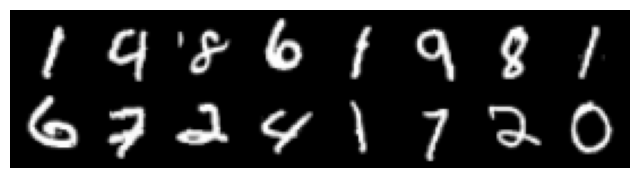

In [10]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape}")
print(f"Lables shape: {label.shape} ")


plt.figure(figsize = (8,8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(img[:16], padding = 2, normalize= True), (1, 2, 0 )))
plt.show()

In [11]:
class PytorchLeNet(nn.Module): 
    def __init__(self, num_classes, grayscale = False):
        super(PytorchLeNet, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes
        
        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
model = PytorchLeNet(num_classes=10, grayscale=True)
summary = torchinfo.summary(model, (32, 1, 32, 32), 
                            col_names=("input_size", "output_size", "num_params"),
                            col_width=18)

summary

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #
PytorchLeNet                             [32, 1, 32, 32]    [32, 10]           --
├─Sequential: 1-1                        [32, 1, 32, 32]    [32, 16, 5, 5]     --
│    └─Conv2d: 2-1                       [32, 1, 32, 32]    [32, 6, 28, 28]    156
│    └─Tanh: 2-2                         [32, 6, 28, 28]    [32, 6, 28, 28]    --
│    └─MaxPool2d: 2-3                    [32, 6, 28, 28]    [32, 6, 14, 14]    --
│    └─Conv2d: 2-4                       [32, 6, 14, 14]    [32, 16, 10, 10]   2,416
│    └─Tanh: 2-5                         [32, 16, 10, 10]   [32, 16, 10, 10]   --
│    └─MaxPool2d: 2-6                    [32, 16, 10, 10]   [32, 16, 5, 5]     --
├─Sequential: 1-2                        [32, 400]          [32, 10]           --
│    └─Linear: 2-7                       [32, 400]          [32, 120]          48,120
│    └─Tanh: 2-8                         [32, 120]          [32, 120]          --
│  

In [18]:
from tqdm import tqdm 


def train(model, train_dataloader, test_dataloader, epochs, criterion, optimizer, device, scheduler = None):
    """
    This function trains the model
    
    Parameters
    ----------
    model: nn.Module
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    epochs: int
    criterion: nn.Module
    optimizer: nn.Module
    device: str
    """
    
    model.to(device)
    
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        training_loss, training_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            training_acc += (outputs.argmax(1) == labels).float().mean()
            training_acc = training_acc.item()
            
        scheduler.step()
        epoch_loss_tr = training_loss / len(train_dataloader)
        epoch_acc_tr = training_acc / len(train_dataloader)
        
        print(f'Epoch: {epoch} Training Loss: {epoch_loss_tr}, Training Accuracy: {epoch_acc_tr}')
        
        model.eval()
        test_loss, test_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            test_acc += (outputs.argmax(1) == labels).float().mean()
            test_acc = test_acc.item()
            
        epoch_loss_te = test_loss / len(test_dataloader)
        epoch_acc_te = test_acc / len(test_dataloader)
        
        
        
        
        print(f'Epoch: {epoch} Validation Loss: {epoch_loss_te}, Validation Accuracy: {epoch_acc_te}')
    
        results['train_loss'].append(epoch_loss_tr)
        results['train_acc'].append(epoch_acc_tr)
        results['val_loss'].append(epoch_loss_te)
        results['val_acc'].append(epoch_acc_te)
        
    return model, results

In [19]:
pytorch_model = PytorchLeNet(num_classes = 10, grayscale=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)

pytorch_model, results = train(pytorch_model, train_dataloader, test_dataloader, NUM_EPOCHS, criterion, optimizer, device, scheduler)

 20%|██        | 1/5 [00:03<00:13,  3.39s/it]

Epoch: 0 Training Loss: 0.2063176459672614, Training Accuracy: 0.9371494391025641
Epoch: 0 Validation Loss: 0.09271312939623992, Validation Accuracy: 0.9705528846153846


 40%|████      | 2/5 [00:06<00:10,  3.41s/it]

Epoch: 1 Training Loss: 0.04834827029695495, Training Accuracy: 0.9857772435897436
Epoch: 1 Validation Loss: 0.045810492609281286, Validation Accuracy: 0.9846754807692307


 60%|██████    | 3/5 [00:10<00:06,  3.37s/it]

Epoch: 2 Training Loss: 0.03128881541152413, Training Accuracy: 0.9915030715811965
Epoch: 2 Validation Loss: 0.04372556922205079, Validation Accuracy: 0.9859775641025641


 80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

Epoch: 3 Training Loss: 0.029685566225686133, Training Accuracy: 0.9920372596153846
Epoch: 3 Validation Loss: 0.04364363180819708, Validation Accuracy: 0.9859775641025641


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

Epoch: 4 Training Loss: 0.02951456310474274, Training Accuracy: 0.9921374198717948
Epoch: 4 Validation Loss: 0.04363420125670158, Validation Accuracy: 0.9859775641025641


<Axes: xlabel='Epoch', ylabel='ACC'>

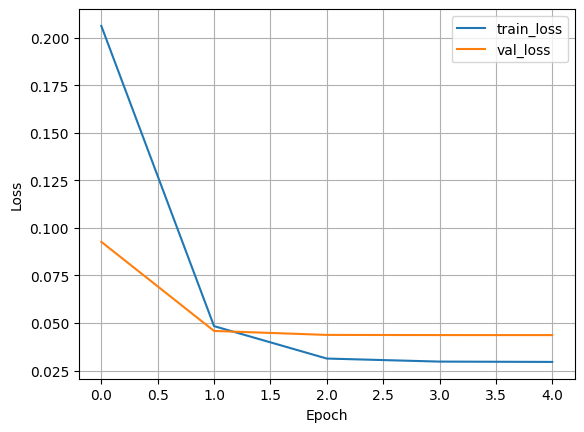

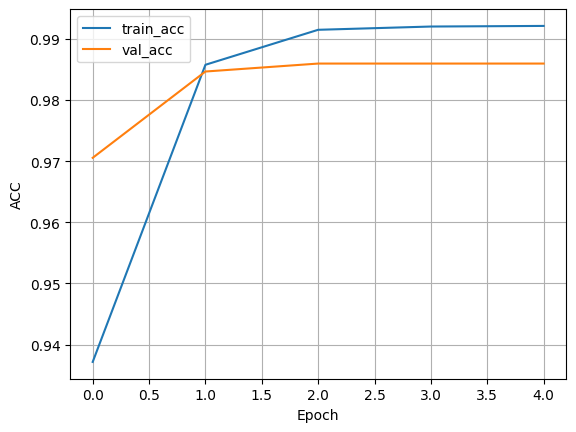

In [20]:
df_metrics = pd.DataFrame(results)

df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

In [21]:
y_preds = []

pytorch_model.eval()
with torch.inference_mode(): 
    for X, y in tqdm(test_dataloader): 
        X, y = X.to(device), y.to(device)
        logits = pytorch_model(X)
        pred = torch.argmax(logits, dim = 1)
        
        y_preds.append(pred)
        
y_preds = torch.cat(y_preds, dim = 0)
test_truth = torch.cat([y for _, y in test_dataloader], dim = 0 )

100%|██████████| 39/39 [00:00<00:00, 297.22it/s]


/var/folders/vq/zk2fmtnd52x9shn3q484yglm0000gn/T/ipykernel_29422/1175220450.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


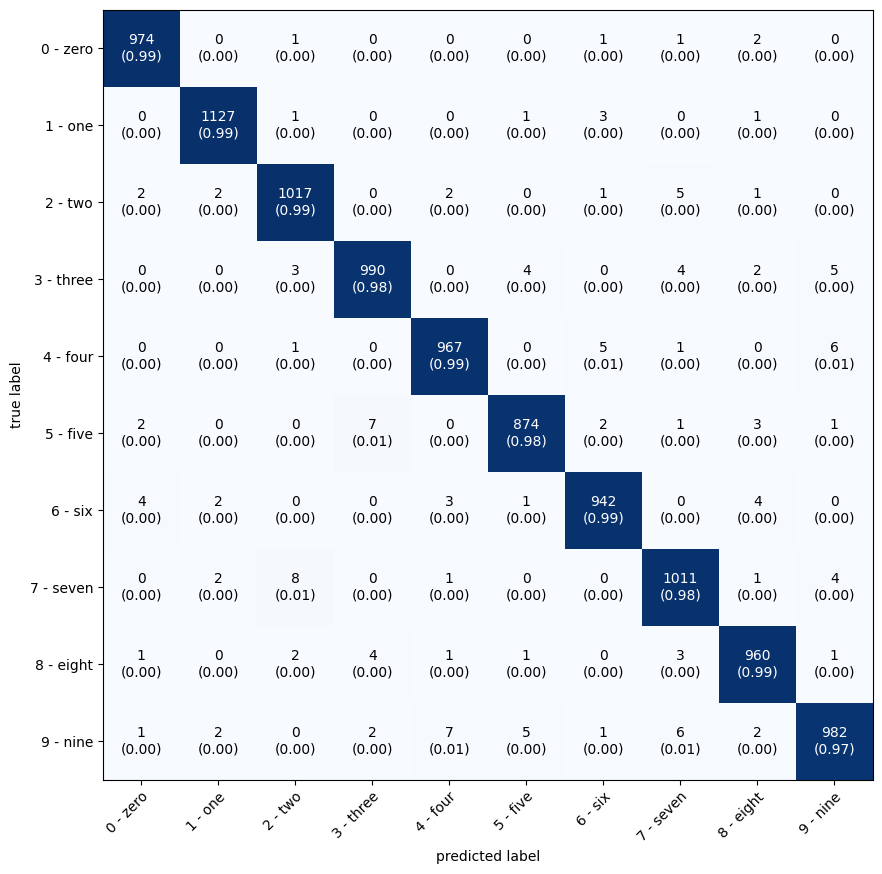

In [22]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)
confmat_tensor = confmat(y_preds.to(device), test_truth.to(device))
confmat_tensor = confmat_tensor.cpu()

fig, ax = plot_confusion_matrix(confmat_tensor.numpy(), figsize=(10, 10), class_names=class_names, show_normed=True)
fig.show()